In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
logging.getLogger('urllib3').setLevel(level=logging.CRITICAL)
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)

from easydev import Logging as elogging
elogging.level = "CRITICAL"

import warnings
warnings.filterwarnings("ignore" )

import networkx as nx
import matplotlib.pyplot as plt

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


# PPI Networks and Structural Interactomics
## Config
Global parameters are stored in Config objects. We have a global `GRNGraphConfig` that contains a `TRRUSTConfig` and a `RegNetworkConfig` for parameters relating to each of the two sources.


In [8]:
from graphein.ppi.config import PPIGraphConfig
config = PPIGraphConfig()
config

PPIGraphConfig(paginate=True, ncbi_taxon_id=9606, kwargs={'STRING_escore': 0.2, 'BIOGRID_throughputTag': 'high'}, string_config=None, biogrid_config=None)

We also need a list of proteins to work from. Let's use these:

In [9]:
protein_list = ["CDC42", "CDK1", "KIF23", "PLK1", "RAC2", "RACGAP1", "RHOA", "RHOB"]

In [10]:
from graphein.ppi.graphs import compute_ppi_graph
from graphein.ppi.edges import add_string_edges, add_biogrid_edges

edge_construction_funcs=[add_string_edges, add_biogrid_edges]

g = compute_ppi_graph(config=config,
                      protein_list=protein_list,
                      edge_construction_funcs=edge_construction_funcs
                     )

DEBUG:graphein.ppi.graphs:Added 8 nodes to graph
DEBUG:graphein.ppi.edges:Added 44 string interaction edges
DEBUG:graphein.ppi.edges:Added 15 biogrid interaction edges


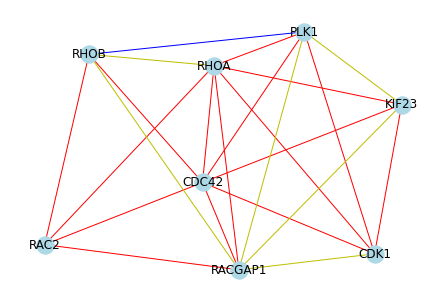

In [11]:
edge_colors = [
    "r"
    if g[u][v]["kind"] == {"string"}
    else "b"
    if g[u][v]["kind"] == {"biogrid"}
    else "y"
    for u, v in g.edges()
]

nx.draw(g, with_labels=True, node_color="lightblue", edge_color=edge_colors)

In [12]:
g.edges(data=True)

EdgeDataView([('CDC42', 'RAC2', {'kind': {'string'}}), ('CDC42', 'PLK1', {'kind': {'string'}}), ('CDC42', 'RHOB', {'kind': {'string'}}), ('CDC42', 'RHOA', {'kind': {'string'}}), ('CDC42', 'CDK1', {'kind': {'string'}}), ('CDC42', 'RACGAP1', {'kind': {'string'}}), ('CDC42', 'KIF23', {'kind': {'string'}}), ('CDK1', 'KIF23', {'kind': {'string'}}), ('CDK1', 'RHOA', {'kind': {'string'}}), ('CDK1', 'RACGAP1', {'kind': {'biogrid', 'string'}}), ('CDK1', 'PLK1', {'kind': {'string'}}), ('KIF23', 'PLK1', {'kind': {'biogrid', 'string'}}), ('KIF23', 'RHOA', {'kind': {'string'}}), ('KIF23', 'RACGAP1', {'kind': {'biogrid', 'string'}}), ('PLK1', 'RHOA', {'kind': {'string'}}), ('PLK1', 'RACGAP1', {'kind': {'biogrid', 'string'}}), ('PLK1', 'RHOB', {'kind': {'biogrid'}}), ('RAC2', 'RHOB', {'kind': {'string'}}), ('RAC2', 'RHOA', {'kind': {'string'}}), ('RAC2', 'RACGAP1', {'kind': {'string'}}), ('RACGAP1', 'RHOB', {'kind': {'biogrid', 'string'}}), ('RACGAP1', 'RHOA', {'kind': {'string'}}), ('RHOA', 'RHOB', 

## Node Metadata
Cool! Let's add some metadata to our nodes in the form of sequences and UniProt IDs

In [15]:
from functools import partial

from graphein.ppi.graph_metadata import add_biogrid_metadata, add_string_metadata, add_string_biogrid_metadata
from graphein.ppi.features.node_features import add_sequence_to_nodes

g = compute_ppi_graph(config=config,
                      protein_list=protein_list,
                      edge_construction_funcs= edge_construction_funcs,
                      #graph_annotation_funcs = [partial(add_string_biogrid_metadata, kwargs=None)],
                      node_annotation_funcs=[add_sequence_to_nodes]
                     )

DEBUG:graphein.ppi.graphs:Added 8 nodes to graph
DEBUG:graphein.ppi.edges:Added 44 string interaction edges
DEBUG:graphein.ppi.edges:Added 15 biogrid interaction edges


In [16]:
for n, d in g.nodes(data=True):
    print(d)

{'protein_id': 'CDC42', 'uniprot_ids': ['P60953'], 'sequence_P60953': 'MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMIGGEPYTLGLFDTAGQEDYDRLRPLSYPQTDVFLVCFSVVSPSSFENVKEKWVPEITHHCPKTPFLLVGTQIDLRDDPSTIEKLAKNKQKPITPETAEKLARDLKAVKYVECSALTQKGLKNVFDEAILAALEPPEPKKSRRCVLL'}
{'protein_id': 'CDK1', 'uniprot_ids': ['P06493'], 'sequence_P06493': 'MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPSTAIREISLLKELRHPNIVSLQDVLMQDSRLYLIFEFLSMDLKKYLDSIPPGQYMDSSLVKSYLYQILQGIVFCHSRRVLHRDLKPQNLLIDDKGTIKLADFGLARAFGIPIRVYTHEVVTLWYRSPEVLLGSARYSTPVDIWSIGTIFAELATKKPLFHGDSEIDQLFRIFRALGTPNNEVWPEVESLQDYKNTFPKWKPGSLASHVKNLDENGLDLLSKMLIYDPAKRISGKMALNHPYFNDLDNQIKKM'}
{'protein_id': 'KIF23', 'uniprot_ids': ['Q02241'], 'sequence_Q02241': 'MKSARAKTPRKPTVKKGSQTNLKDPVGVYCRVRPLGFPDQECCIEVINNTTVQLHTPEGYRLNRNGDYKETQYSFKQVFGTHTTQKELFDVVANPLVNDLIHGKNGLLFTYGVTGSGKTHTMTGSPGEGGLLPRCLDMIFNSIGSFQAKRYVFKSNDRNSMDIQCEVDALLERQKREAMPNPKTSSSKRQVDPEFADMITVQEFCKAEEVDEDSVYGVFVSYIEIYNNYIYDLLEEVPFDPIKPKPPQSKLLREDKNHNMYVAGCTEVEVKSTEEAFEVFWRGQKKRRIANTHL

## Structural Interactomics with AlphaFold2

Let's look at a structural interactome! We can add protein graphs to the nodes in our interaction graph. Cool, eh? We think so

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 191 total nodes
DEBUG:graphein.protein.features.nodes.amino_acid:Reading meiler embeddings from: /home/atj39/github/graphein/graphein/protein/features/nodes/meiler_embeddings.csv


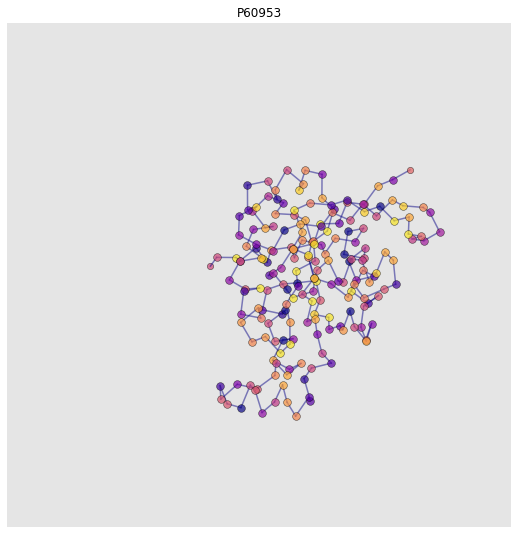

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 297 total nodes


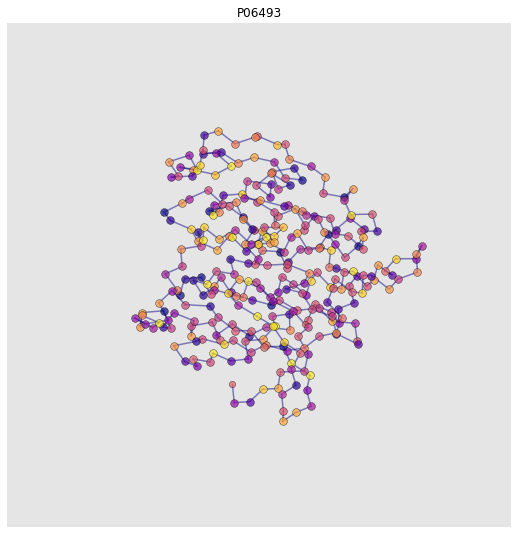

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 960 total nodes


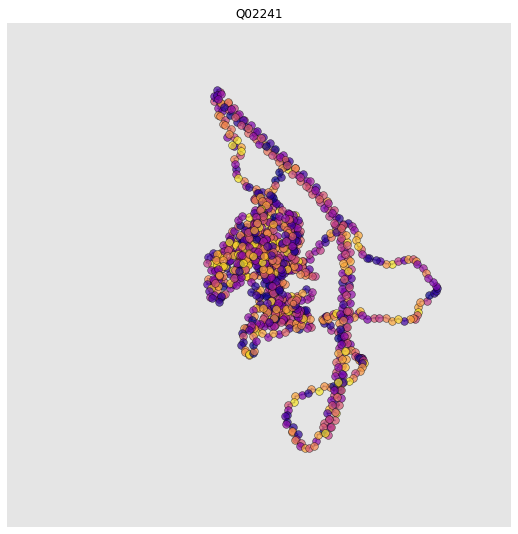

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 603 total nodes


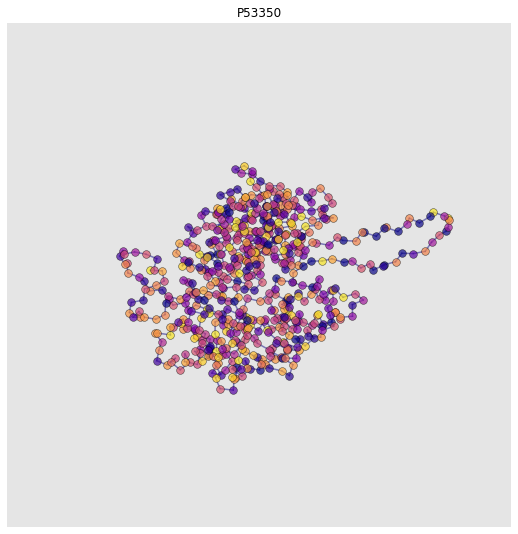

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 192 total nodes


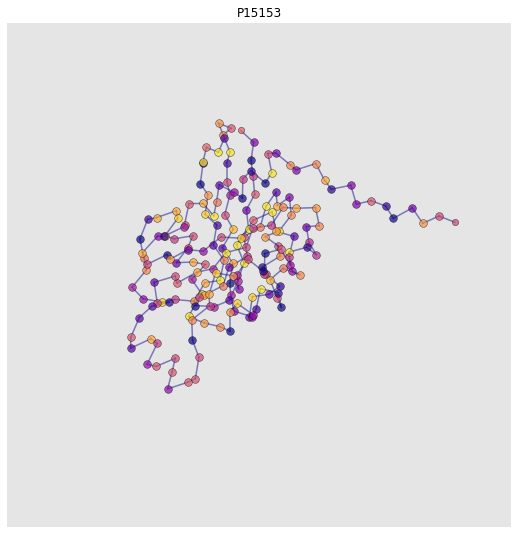

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 632 total nodes


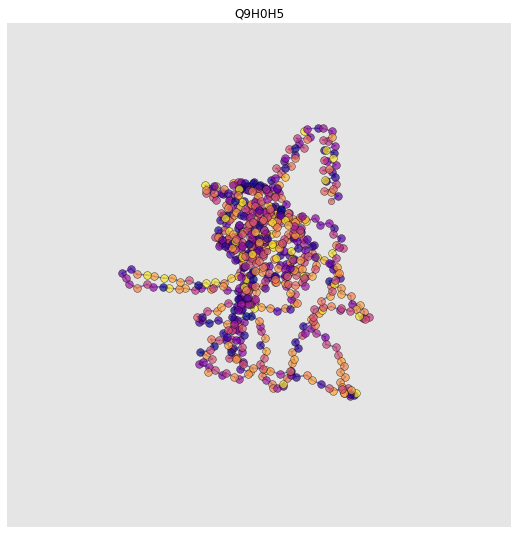

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 193 total nodes


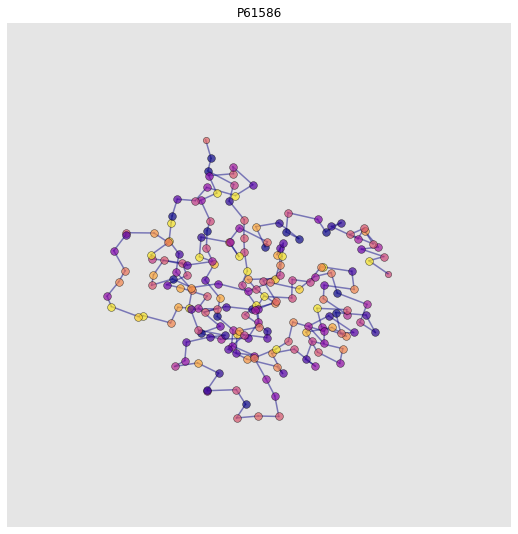

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 196 total nodes


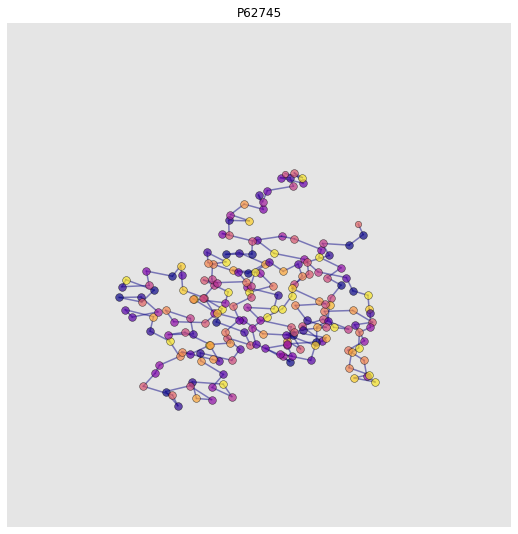

In [17]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.utils import download_alphafold_structure
from graphein.protein.visualisation import plot_protein_structure_graph

pg_config = ProteinGraphConfig()


for n, d in g.nodes(data=True):
    try:
        fp = download_alphafold_structure(d['uniprot_ids'][0])[0]
        pg = construct_graph(pg_config, pdb_path=fp)
    
        # Add protein graph as node feature
        d['protein_graph'] = pg
    
        # Plot
        ax = plot_protein_structure_graph(pg, label_node_ids=False, colour_nodes_by="residue_name")
        ax.set_title(d["uniprot_ids"][0])
        plt.show()
    except:
        continue

Let's checkout the metadata again:

In [18]:
for n, d in g.nodes(data=True):
    print(d)

{'protein_id': 'CDC42', 'uniprot_ids': ['P60953'], 'sequence_P60953': 'MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMIGGEPYTLGLFDTAGQEDYDRLRPLSYPQTDVFLVCFSVVSPSSFENVKEKWVPEITHHCPKTPFLLVGTQIDLRDDPSTIEKLAKNKQKPITPETAEKLARDLKAVKYVECSALTQKGLKNVFDEAILAALEPPEPKKSRRCVLL', 'protein_graph': <networkx.classes.graph.Graph object at 0x7f88d5b39be0>}
{'protein_id': 'CDK1', 'uniprot_ids': ['P06493'], 'sequence_P06493': 'MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPSTAIREISLLKELRHPNIVSLQDVLMQDSRLYLIFEFLSMDLKKYLDSIPPGQYMDSSLVKSYLYQILQGIVFCHSRRVLHRDLKPQNLLIDDKGTIKLADFGLARAFGIPIRVYTHEVVTLWYRSPEVLLGSARYSTPVDIWSIGTIFAELATKKPLFHGDSEIDQLFRIFRALGTPNNEVWPEVESLQDYKNTFPKWKPGSLASHVKNLDENGLDLLSKMLIYDPAKRISGKMALNHPYFNDLDNQIKKM', 'protein_graph': <networkx.classes.graph.Graph object at 0x7f88d553d9d0>}
{'protein_id': 'KIF23', 'uniprot_ids': ['Q02241'], 'sequence_Q02241': 'MKSARAKTPRKPTVKKGSQTNLKDPVGVYCRVRPLGFPDQECCIEVINNTTVQLHTPEGYRLNRNGDYKETQYSFKQVFGTHTTQKELFDVVANPLVNDLIHGKNGLLFTYGVTGSGKTHTMTGSPGEGGLLPRCLDMIFNSIGSF

## Plot SARS-CoV-2 host-virus proteins (Gordon et al., 2020)

List of human interacting proteins (`protein_list`) retrieved from:

Gordon et al. (2020). A SARS-CoV-2-Human Protein-Protein Interaction Map Reveals Drug Targets and Potential Drug-Repurposing. [[paper](https://www.biorxiv.org/content/10.1101/2020.03.22.002386v2)]

DEBUG:graphein.ppi.graphs:Added 332 nodes to graph
DEBUG:graphein.ppi.edges:Added 1856 string interaction edges
DEBUG:graphein.ppi.edges:Added 1721 biogrid interaction edges


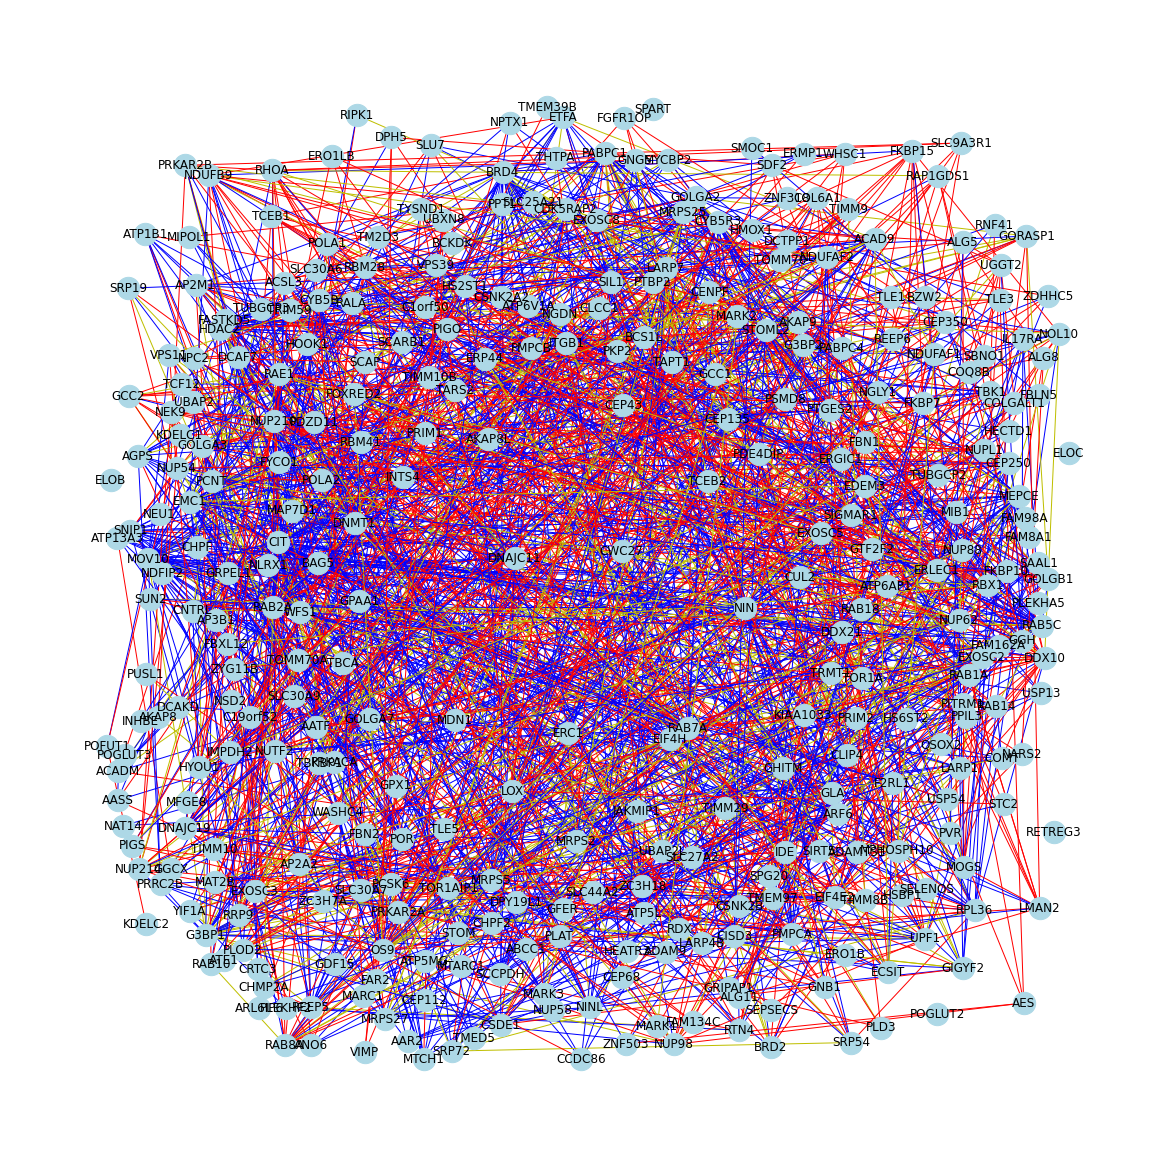

In [23]:
protein_list = ['AP3B1', 'BRD4', 'BRD2', 'CWC27', 'ZC3H18', 'SLC44A2', 'PMPCB',
       'YIF1A', 'ATP1B1', 'ACADM', 'ETFA', 'STOM', 'GGCX', 'ATP6V1A',
       'PSMD8', 'REEP5', 'PMPCA', 'ANO6', 'PITRM1', 'SLC30A9', 'FASTKD5',
       'SLC30A7', 'TUBGCP3', 'COQ8B', 'SAAL1', 'REEP6', 'INTS4',
       'SLC25A21', 'TUBGCP2', 'TARS2', 'RTN4', 'FAM8A1', 'AASS', 'AKAP8L',
       'AAR2', 'BZW2', 'RRP9', 'PABPC1', 'CSNK2A2', 'CSNK2B', 'G3BP1',
       'PABPC4', 'LARP1', 'FAM98A', 'SNIP1', 'UPF1', 'MOV10', 'G3BP2',
       'DDX21', 'RBM28', 'RPL36', 'GOLGA7', 'ZDHHC5', 'POLA1', 'PRIM1',
       'PRIM2', 'POLA2', 'COLGALT1', 'PKP2', 'AP2A2', 'GFER', 'ERGIC1',
       'AP2M1', 'GRPEL1', 'TBCA', 'SBNO1', 'BCKDK', 'AKAP8', 'MYCBP2',
       'SLU7', 'RIPK1', 'UBAP2L', 'TYSND1', 'PDZD11', 'PRRC2B', 'UBAP2',
       'ZNF318', 'CRTC3', 'USP54', 'ZC3H7A', 'LARP4B', 'RBM41', 'TCF12',
       'PPIL3', 'PLEKHA5', 'TBKBP1', 'CIT', 'HSBP1', 'PCNT', 'CEP43',
       'PRKAR2A', 'PRKACA', 'PRKAR2B', 'RDX', 'CENPF', 'TLE1', 'TLE3',
       'TLE5', 'GOLGA3', 'GOLGA2', 'GOLGB1', 'GRIPAP1', 'CEP350',
       'PDE4DIP', 'CEP135', 'CEP68', 'CNTRL', 'ERC1', 'GCC2', 'CLIP4',
       'NIN', 'CEP112', 'MIPOL1', 'USP13', 'GCC1', 'JAKMIP1', 'CDK5RAP2',
       'AKAP9', 'GORASP1', 'FYCO1', 'C1orf50', 'CEP250', 'TBK1', 'HOOK1',
       'NINL', 'GLA', 'IMPDH2', 'SIRT5', 'NUTF2', 'ARF6', 'RNF41',
       'SLC27A2', 'EIF4E2', 'POR', 'RAP1GDS1', 'WASHC4', 'FKBP15',
       'GIGYF2', 'IDE', 'TIMM10', 'ALG11', 'NUP210', 'TIMM29', 'DNAJC11',
       'TIMM10B', 'TIMM9', 'HDAC2', 'GPX1', 'TRMT1', 'ATP5MG', 'ATP6AP1',
       'SIGMAR1', 'ATP13A3', 'AGPS', 'CYB5B', 'ACSL3', 'CYB5R3', 'RALA',
       'COMT', 'RAB5C', 'RAB7A', 'RAB8A', 'RAB2A', 'RAB10', 'RAB14',
       'RHOA', 'RAB1A', 'GNB1', 'GNG5', 'LMAN2', 'MOGS', 'TOR1AIP1',
       'MTARC1', 'QSOX2', 'HS2ST1', 'NDUFAF2', 'SCCPDH', 'SCARB1',
       'NAT14', 'DCAKD', 'FAM162A', 'DNAJC19', 'SELENOS', 'PTGES2',
       'RAB18', 'MPHOSPH10', 'SRP72', 'ATE1', 'NSD2', 'SRP19', 'SRP54',
       'MRPS25', 'DDX10', 'LARP7', 'MEPCE', 'NGDN', 'EXOSC8', 'NARS2',
       'NOL10', 'CCDC86', 'SEPSECS', 'EXOSC5', 'EXOSC3', 'AATF', 'HECTD1',
       'MRPS2', 'MRPS5', 'EXOSC2', 'MRPS27', 'GTF2F2', 'FBN1', 'FBN2',
       'NUP214', 'NUP62', 'DCAF7', 'EIF4H', 'NUP54', 'MIB1', 'SPART',
       'NEK9', 'ZNF503', 'NUP88', 'NUP58', 'MAT2B', 'FBLN5', 'PPT1',
       'CUL2', 'MAP7D1', 'THTPA', 'ZYG11B', 'TIMM8B', 'RBX1', 'ELOC',
       'ELOB', 'HMOX1', 'TRIM59', 'ARL6IP6', 'VPS39', 'CLCC1', 'VPS11',
       'SUN2', 'ALG5', 'STOML2', 'NUP98', 'RAE1', 'MTCH1', 'HEATR3',
       'MDN1', 'PLOD2', 'TOR1A', 'STC2', 'PLAT', 'ITGB1', 'CISD3',
       'COL6A1', 'PVR', 'DNMT1', 'LOX', 'PCSK6', 'INHBE', 'NPC2', 'MFGE8',
       'OS9', 'NPTX1', 'POGLUT2', 'POGLUT3', 'ERO1B', 'PLD3', 'FOXRED2',
       'CHPF', 'PUSL1', 'EMC1', 'GGH', 'ERLEC1', 'IL17RA', 'NGLY1',
       'HS6ST2', 'SDF2', 'NEU1', 'GDF15', 'TM2D3', 'ERP44', 'EDEM3',
       'SIL1', 'POFUT1', 'SMOC1', 'PLEKHF2', 'FBXL12', 'UGGT2', 'CHPF2',
       'ADAMTS1', 'HYOU1', 'FKBP7', 'ADAM9', 'FKBP10', 'SLC9A3R1',
       'CHMP2A', 'CSDE1', 'TOMM70', 'MARK3', 'MARK2', 'DPH5', 'DCTPP1',
       'MARK1', 'PTBP2', 'BAG5', 'UBXN8', 'GPAA1', 'WFS1', 'ABCC1',
       'F2RL1', 'SCAP', 'DPY19L1', 'TMEM97', 'SLC30A6', 'TAPT1', 'ERMP1',
       'NLRX1', 'RETREG3', 'PIGO', 'FAR2', 'ECSIT', 'ALG8', 'TMEM39B',
       'GHITM', 'ACAD9', 'NDFIP2', 'BCS1L', 'NDUFAF1', 'TMED5', 'NDUFB9',
       'PIGS']

config = PPIGraphConfig()

g = compute_ppi_graph(config=config, protein_list=protein_list, edge_construction_funcs=edge_construction_funcs)

# Plot output network
plt.figure(figsize=(16, 16))
nx_pos = nx.spring_layout(g, k=0.5, iterations=3)

edge_colors = [
    "r"
    if g[u][v]["kind"] == {"string"}
    else "b"
    if g[u][v]["kind"] == {"biogrid"}
    else "y"
    for u, v in g.edges()
]

nx.draw(g, nx_pos, with_labels=True, node_color="lightblue", edge_color=edge_colors, node_size=500)